## Utility Functions
The following code are modified from a [public Kaggle notebook](https://www.kaggle.com/code/negoto/h-m-framework-for-partitioned-validation/notebook).

In [1]:
from IPython.display import display
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] <= 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, score=None, figsize=(12, 6), kaggle_score=None, eval_week=None, name=None, verbose=False):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    if eval_week > 104: return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if score is None: 
        score = pd.DataFrame(columns=['name'])
    
    index = score.shape[0]
    score.loc[index, "name"] = name
    score.loc[index, "map@12"] = map12
    score.loc[index, "eval_week"] = eval_week
    score.loc[index, "kaggle_score"] = kaggle_score
    if verbose:
        plt.figure(figsize=figsize)
        sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {map12}")
    vc = pd.Series(predicted).apply(len).value_counts()
    score.loc[index, "fill"] = round(1 - sum(vc[k] * (12 - k) / 12 \
        for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
    if verbose:
        display(score)
    return score

def get_eval_data(df, eval_week):
    # final week is 104; set val_week = 105 if you would like to create a submission
    val = df.loc[df.week == eval_week].groupby('customer_id').article_id.apply(iter_to_str).reset_index()\
        .merge(cid, on='customer_id', how='right')
    val = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())
    return val

def validate_submission(
    submission, target, kaggle_score=None, eval_week=None, 
    saved_scores=None, dir='submit', name=None):
    if isinstance(submission, str):
        submission = pd.read_csv(f"{dir}/{submission}.csv", dtype={'customer_id':'str'})
    predicted = submission['prediction'].apply(lambda s: [] if pd.isna(s) else s.split())
    return validation(target, predicted, saved_scores, kaggle_score=kaggle_score, eval_week=eval_week, name=name)

In [3]:
# uncomment to install fastparquet package for working with parquest files
# %conda install fastparquet -c conda-forge

The parquet version of the H\&M dataset can be found [here](https://www.kaggle.com/datasets/negoto/hm-parquets-of-datasets)

In [4]:
df = pd.read_parquet('./input/transactions_train.parquet')
sub = pd.read_csv('./input/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))

We use the last 4 weeks in training set and use the weekly MAP@12 scores as the performance metrics. 

In [5]:
eval_weeks = range(101, 105)
eval_data_by_week = {t : get_eval_data(df, t) for t in eval_weeks}


## Evluate submissions with weekly MAP@12

In [6]:
eval_scores = None

sub = pd.read_csv(f"./submit/240_public.csv", dtype={'customer_id':'str'})
for t in eval_weeks:
    target = eval_data_by_week[t]
    eval_scores = validate_submission(
        submission=sub, name="best_public", kaggle_score=0.0240,
        target= eval_data_by_week[t], eval_week=t,
        saved_scores=eval_scores)

display(eval_scores)

,name,map@12,eval_week,kaggle_score,fill
0,best_public,0.678900,101.0,0.024,100.0
1,best_public,0.760453,102.0,0.024,100.0
2,best_public,0.843500,103.0,0.024,100.0
3,best_public,0.936170,104.0,0.024,100.0


In [7]:
sub = pd.read_csv(f"./submit/0_0225_SASRec.csv", dtype={'customer_id':'str'})
for t in eval_weeks:
    target = eval_data_by_week[t]
    eval_scores = validate_submission(
        submission=sub, name="SASRecF", kaggle_score=0.0225,
        target=eval_data_by_week[t], eval_week=t,
        saved_scores=eval_scores)

display(eval_scores)

,name,map@12,eval_week,kaggle_score,fill
0,best_public,0.678900,101.0,0.0240,100.0
1,best_public,0.760453,102.0,0.0240,100.0
2,best_public,0.843500,103.0,0.0240,100.0
3,best_public,0.936170,104.0,0.0240,100.0
4,SASRecF,0.638645,101.0,0.0225,100.0
5,SASRecF,0.723856,102.0,0.0225,100.0
6,SASRecF,0.795760,103.0,0.0225,100.0
7,SASRecF,0.891581,104.0,0.0225,100.0


In [8]:
sub = pd.read_csv(f"./submit/0_0237_ensemble.csv", dtype={'customer_id':'str'})
for t in eval_weeks:
    target = eval_data_by_week[t]
    eval_scores = validate_submission(
        submission=sub, name="ensemble_kaggle", kaggle_score=0.0237,
        target=eval_data_by_week[t], eval_week=t,
        saved_scores=eval_scores)

display(eval_scores)

,name,map@12,eval_week,kaggle_score,fill
0,best_public,0.678900,101.0,0.0240,100.0
1,best_public,0.760453,102.0,0.0240,100.0
2,best_public,0.843500,103.0,0.0240,100.0
3,best_public,0.936170,104.0,0.0240,100.0
4,SASRecF,0.638645,101.0,0.0225,100.0
5,SASRecF,0.723856,102.0,0.0225,100.0
6,SASRecF,0.795760,103.0,0.0225,100.0
7,SASRecF,0.891581,104.0,0.0225,100.0
8,ensemble_kaggle,0.662269,101.0,0.0237,100.0
9,ensemble_kaggle,0.753912,102.0,0.0237,100.0


In [9]:
sub = pd.read_csv(f"./submit/submission7_large.csv", dtype={'customer_id':'str'})
for t in eval_weeks:
    target = eval_data_by_week[t]
    eval_scores = validate_submission(
        submission=sub, name="best_ensemble", kaggle_score=0.0244,
        target=eval_data_by_week[t], eval_week=t,
        saved_scores=eval_scores)

display(eval_scores)

,name,map@12,eval_week,kaggle_score,fill
0,best_public,0.678900,101.0,0.0240,100.0
1,best_public,0.760453,102.0,0.0240,100.0
2,best_public,0.843500,103.0,0.0240,100.0
3,best_public,0.936170,104.0,0.0240,100.0
4,SASRecF,0.638645,101.0,0.0225,100.0
5,SASRecF,0.723856,102.0,0.0225,100.0
6,SASRecF,0.795760,103.0,0.0225,100.0
7,SASRecF,0.891581,104.0,0.0225,100.0
8,ensemble_kaggle,0.662269,101.0,0.0237,100.0
9,ensemble_kaggle,0.753912,102.0,0.0237,100.0


In [10]:
sub = pd.read_csv(f"./submit/BERT4Rec-Apr-22-2022_01-43-12.csv", dtype={'customer_id':'str'})
for t in eval_weeks:
    target = eval_data_by_week[t]
    eval_scores = validate_submission(
        submission=sub, name="BERT4Rec", kaggle_score=0.0161,
        target=eval_data_by_week[t], eval_week=t,
        saved_scores=eval_scores)

display(eval_scores)

,name,map@12,eval_week,kaggle_score,fill
0,best_public,0.678900,101.0,0.0240,100.0
1,best_public,0.760453,102.0,0.0240,100.0
2,best_public,0.843500,103.0,0.0240,100.0
3,best_public,0.936170,104.0,0.0240,100.0
4,SASRecF,0.638645,101.0,0.0225,100.0
5,SASRecF,0.723856,102.0,0.0225,100.0
6,SASRecF,0.795760,103.0,0.0225,100.0
7,SASRecF,0.891581,104.0,0.0225,100.0
8,ensemble_kaggle,0.662269,101.0,0.0237,100.0
9,ensemble_kaggle,0.753912,102.0,0.0237,100.0


### Plot MAP@12 by week

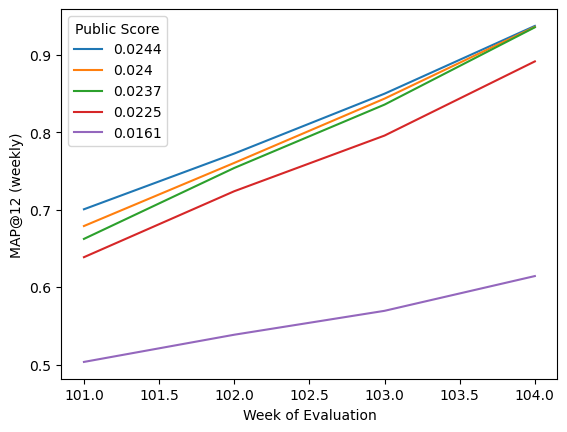

In [11]:
plt.style.use('default')
df = eval_scores.sort_values('kaggle_score', ascending=False)

fig, ax = plt.subplots()

for mod in df.name.unique():
    tmp =  df[df.name == mod]
    plt.plot(tmp['eval_week'], tmp['map@12'], label=tmp.kaggle_score.iloc[0])

ax.set_ylabel('MAP@12 (weekly)')
ax.set_xlabel('Week of Evaluation')
plt.legend(title="Public Score")
plt.show()